# RFM기반 군집분석

In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

rfm_file = "RFM_Score.csv"
rfm_df = pd.read_csv(rfm_file, encoding="utf-8")

rfm_features = rfm_df[["Recency", "Frequency", "Monetary"]]         

# 데이터 정규화
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# 최적 K 찾기 (엘보우 방법)
distortions = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    distortions.append(kmeans.inertia_)

# K-Means 클러스터링 (K=4 )
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_df["클러스터"] = kmeans.fit_predict(rfm_scaled)

# 클러스터별 평균 RFM 값 
cluster_analysis = rfm_df.groupby("클러스터")[["Recency", "Frequency", "Monetary"]].mean().reset_index()
cluster_analysis

,클러스터,Recency,Frequency,Monetary
0,0,199.894821,6.494371,8.351010e+04
1,1,32.692089,31.096529,3.530412e+05
2,2,1.628415,583.907104,7.706210e+06
3,3,6.934623,200.198799,2.330087e+06


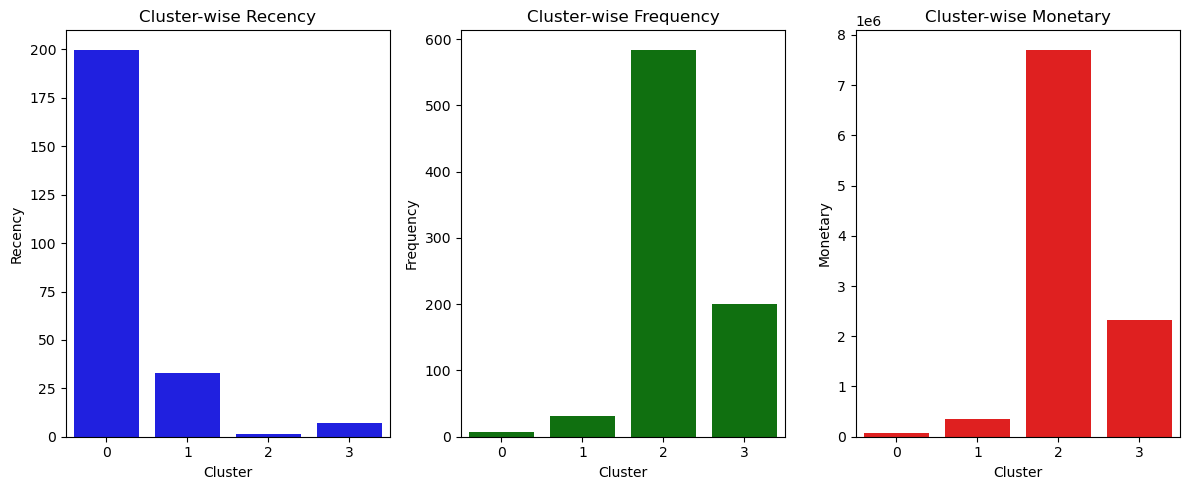

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame({'Cluster': [0, 1, 2, 3],'Recency': [199.89, 32.69, 1.63, 6.93],'Frequency': [6.49, 31.10, 583.91, 200.20],
    'Monetary': [83510, 353041, 7706210, 2330087]})

plt.figure(figsize=(12, 5))
colors = ["blue", "green", "red"]  

for i, col in enumerate(["Recency", "Frequency", "Monetary"]):
    plt.subplot(1, 3, i + 1)
    sns.barplot(x="Cluster", y=col, data=df, color=colors[i])
    plt.title(f"Cluster-wise {col}")

plt.tight_layout()
plt.show()

RFM기반 군집분석

cluster0 : 이탈 가능성이 높은 고객 → 최근 구매 없음, 구매 빈도 낮음, 낮은 구매금액

cluster1 : 평범 고객 → 자주 구매하지만, 구매 금액이 중간 수준

cluster2 : 최우수 고객 → 매우 빈번한 구매, 높은 구매 금액

cluster3 : 과거 우수고객이었지만 최근 구매가 줄어든 고객

# 고객특성기반 군집 분석

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

df_member = pd.read_csv("Member_Data.csv", encoding="cp949")

# 컬럼 선택 
customer_data = df_member[["나이", "성별", "결혼", "구독여부"]].fillna("미정")
customer_data["구독여부"] = customer_data["구독여부"].astype(str)  # 타입을 문자열로 변환

# 데이터 변환
column_transformer = ColumnTransformer([('num', StandardScaler(), ["나이"]),
    ('cat', OneHotEncoder(handle_unknown='ignore', dtype=int), ["성별", "결혼", "구독여부"])])

# K-Means 클러스터링 (K=4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_data["클러스터"] = kmeans.fit_predict(column_transformer.fit_transform(customer_data))

customer_data

,나이,성별,결혼,구독여부,클러스터
0,68,여,기혼,False,0
1,83,남,미정,False,0
2,39,여,기혼,False,1
3,73,여,미정,미정,0
4,52,여,기혼,False,0
...,...,...,...,...,...
12535,34,여,미혼,False,3
12536,24,남,미혼,False,3
12537,28,남,미정,False,2
12538,19,남,미혼,미정,3


클러스터별 구독률 비율

In [31]:
# 파일 로드
file_path = "customer_data.csv"
df = pd.read_csv(file_path)

# 클러스터별 구독 여부 비율 계산
subscription_counts = df.groupby(["클러스터", "구독여부"]).size().unstack()

# 클러스터별 구독률(%) 계산
subscription_rates = subscription_counts.div(subscription_counts.sum(axis=1), axis=0) * 100

# 결과 출력
print(subscription_rates)

구독여부      False       True         미정
클러스터                                 
0     67.359667  15.280665  17.359667
1     67.652262  13.393985  18.953753
2     66.192508  13.655761  20.151731
3     67.558528  13.768116  18.673356


In [35]:
# 클러스터별 나이의 평균 및 분포 확인
age_distribution = df.groupby("클러스터")["나이"].describe()

# 클러스터별 성별 분포 계산
gender_distribution = df.groupby(["클러스터", "성별"]).size().unstack()

# 클러스터별 결혼 여부 분포 계산
marital_distribution = df.groupby(["클러스터", "결혼"]).size().unstack()

print("클러스터별 나이 분포:\n", age_distribution)
print("클러스터별 성별 분포:\n", gender_distribution)
print("클러스터별 결혼 여부 분포:\n", marital_distribution)

클러스터별 나이 분포:
        count       mean       std   min   25%   50%   75%    max
클러스터                                                            
0     2886.0  59.041580  6.893370  50.0  54.0  58.0  63.0  100.0
1     3957.0  36.359616  6.395684  18.0  32.0  36.0  41.0   49.0
2     2109.0  36.733049  6.740821  18.0  31.0  37.0  42.0   50.0
3     3588.0  36.524247  6.394321  18.0  32.0  37.0  41.0   49.0
클러스터별 성별 분포:
 성별        남   미정       여
클러스터                    
0     206.0  NaN  2680.0
1     219.0  NaN  3738.0
2     115.0  1.0  1993.0
3     205.0  NaN  3383.0
클러스터별 결혼 여부 분포:
 결혼        기혼      미정      미혼
클러스터                        
0     1202.0   608.0  1076.0
1     3957.0     NaN     NaN
2        NaN  2109.0     NaN
3        NaN     NaN  3588.0


고객특성기반 군집분석

cluster0 : (중장년층 여성), 기혼 비율 높지만 결혼여부 다양하게 분포 50~60대, 여성, 기혼 많음

cluster1 : (기혼 30대 여성), 36세 평균, 여성, 기혼 100% 

cluster2 : (미정 상태 30대 여성), 36.7세 평균, 여성, 결혼 미정 

cluster3 : (미혼 30대 여성), 36.5세 평균, 여성, 미혼 100%

구독률은 클러스터별 큰 차이 없음

# 상품기반 군집분석

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

df_sales = pd.read_csv("Sales_Data05.csv", encoding='cp949')
product_df = pd.read_csv("Product_Data.csv", encoding='utf-8')

# 필요한 컬럼 선택 (회원번호, 제품번호, 구매수량)
sales_data = df_sales[['회원번호', '제품번호', '구매수량']]

# 제품번호 기준으로 제품 대분류 정보 추가
data = sales_data.merge(product_df[['제품번호', '물품대분류']], on='제품번호', how='left')

# 고객별 상품 유형별 구매 수량 Pivot Table
customer_product = data.pivot_table(index='회원번호', columns='물품대분류', values='구매수량', aggfunc='sum', fill_value=0)

# 데이터 표준화
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_product)

# 최적의 K 찾기 
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(customer_scaled)
    inertia.append(kmeans.inertia_)

# K-Means 클러스터링 (K=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(customer_scaled)

# 결과 저장
customer_product['Cluster'] = clusters

# 클러스터별 특성 확인
cluster_summary = customer_product.groupby('Cluster').mean()

cluster_summary

물품대분류,가루,건강일반,건어물,견과,과실주,과일,과일채소,과자,기름/식초,김장채소,...,절임/장아찌,중량(정육),즉석조리,차,찹쌀,콩/화본/깨,콩나물,해조,홍삼/녹용,화장품
Cluster,,,,,,,,,,,,,,,,,,,,,
0,3.307604,1.501252,2.937839,0.926244,0.037164,4.924494,3.991366,9.710612,2.013722,0.000000,...,1.504288,3.599200,1.188679,1.037164,0.627216,1.827330,5.384220,3.562607,0.178193,1.777587
1,0.513531,0.250607,0.368863,0.109813,0.004258,0.410666,0.301817,1.516706,0.261260,0.000000,...,0.183478,0.349451,0.154996,0.197388,0.076079,0.236090,0.741957,0.531510,0.037609,0.272426
2,9.327354,5.370000,8.248879,3.242152,0.192825,23.596637,20.087892,37.055336,6.130045,0.008969,...,3.816143,12.050673,4.349776,2.986547,1.713004,5.529148,11.937220,8.780269,0.649552,7.381166


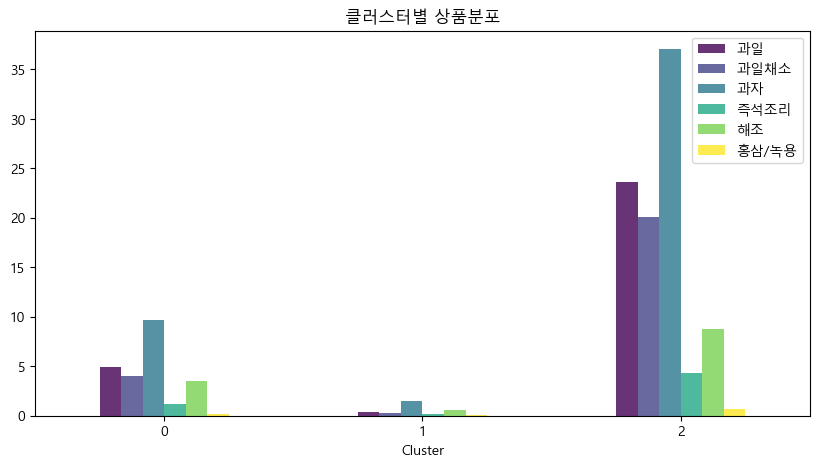

In [47]:
df = pd.DataFrame({"Cluster": [0, 1, 2],"과일": [4.92, 0.41, 23.60], "과일채소": [3.99, 0.30, 20.08],
    "과자": [9.71, 1.52, 37.06],"즉석조리": [1.19, 0.15, 4.35],"해조": [3.56, 0.53, 8.78], "홍삼/녹용": [0.18, 0.04, 0.65]
}).set_index("Cluster")

plt.rc("font", family="Malgun Gothic")

df.plot(kind="bar", figsize=(10, 5), colormap="viridis", alpha=0.8, title="클러스터별 상품분포")
plt.xticks(rotation=0)
plt.show()

상품기반 군집분석

cluster0 : 다양한 품목에서 평범한 소비량을 보이는 군집

cluster1 : 전반적으로 낮은 소비량을 보이는 군집

cluster2 : 압도적으로 높은 소비량을 보이는 군집

# 할인/포인트사용기반 군집분석

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_saels = pd.read_csv("Sales_Data05.csv", encoding='cp949')

# 필요한 컬럼 선택 (회원번호, 사용 적립금, 사용 포인트)
discount_data = df_sales[['회원번호', '사용 적립금', '사용 포인트 네이버']]

# 결측값 처리 (새로운 데이터프레임에 할당)
discount_data = discount_data.copy()
discount_data.fillna(0, inplace=True)

# 데이터 표준화
scaler = StandardScaler()
discount_scaled = scaler.fit_transform(discount_data[['사용 적립금', '사용 포인트 네이버']])

# 최적의 K 찾기 
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(discount_scaled)
    inertia.append(kmeans.inertia_)

# K-Means 클러스터링 (K=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
discount_data['Cluster'] = kmeans.fit_predict(discount_scaled)

# 클러스터별 평균 할인/포인트 사용 패턴 
cluster_summary = discount_data.groupby('Cluster').mean()
cluster_summary

,회원번호,사용 적립금,사용 포인트 네이버
Cluster,,,
0,7.408649e+08,19.394576,53.988632
1,7.332245e+08,457.962963,251600.000000
2,7.297852e+08,7773.125583,61.723817


할인/포인트사용기반 군집분석

cluster0 : 포인트 및 적립금 사용이 적은 고객군

cluster1 : 포인트 활용을 적극적으로 하는 고객군

cluster2 : 적립금을 많이 사용하지만 포인트 사용은 적음

# RFM기반 클러스터별 고객이탈확률 분석

In [6]:
rfm_file = "RFM_Score.csv"
sales_data_file = "Sales_Data05.csv"
member_data_file = "Member_Data.csv"

rfm_df = pd.read_csv(rfm_file, encoding="utf-8")
sales_data = pd.read_csv(sales_data_file, encoding="cp949")
member_data = pd.read_csv(member_data_file, encoding="euc-kr")

# RFM 클러스터링 
rfm_features = rfm_df[["Recency", "Frequency", "Monetary"]]

# 데이터 정규화
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# K-Means 클러스터링 (K=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_df["RFM_Cluster"] = kmeans.fit_predict(rfm_scaled)

# 3. 기존 이탈 예측 모델 데이터 생성
data = sales_data.groupby("회원번호").agg({ "구매수량": "sum", "구매금액": "sum","주문일시": "max"}).reset_index()

# 회원 데이터 병합
data = data.merge(member_data, on="회원번호", how="left")

# 최신 날짜 기준 Recency 계산
data["주문일시"] = pd.to_datetime(data["주문일시"])
latest_date = data["주문일시"].max()
data["days_since_last_purchase"] = (latest_date - data["주문일시"]).dt.days

# 이탈 여부 라벨링 (60일 이상 구매 없음 = 이탈)
data["이탈여부"] = np.where(data["days_since_last_purchase"] > 60, 1, 0)

# RFM 클러스터 정보를 추가
data = data.merge(rfm_df[["회원번호", "RFM_Cluster"]], on="회원번호", how="left")

# 클러스터별 이탈 확률 분석
cluster_churn_rate = data.groupby("RFM_Cluster")["이탈여부"].mean().reset_index()

print(cluster_churn_rate)

   RFM_Cluster      이탈여부
0            0  1.000000
1            1  0.198993
2            2  0.000000
3            3  0.014009


# 고객 특성기반 클러스터별 고객 이탈 확률 분석

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

df_member = pd.read_csv(member_data_file, encoding="cp949")
sales_data = pd.read_csv(sales_data_file, encoding="cp949")

# 고객 특성 데이터 전처리
customer_data = df_member[["회원번호", "나이", "성별", "결혼", "구독여부"]].fillna("미정")
customer_data["구독여부"] = customer_data["구독여부"].astype(str)  # 문자열 변환

# 데이터 변환 (숫자형과 범주형 변수 처리)
column_transformer = ColumnTransformer([
    ('num', StandardScaler(), ["나이"]),
    ('cat', OneHotEncoder(handle_unknown='ignore', dtype=int), ["성별", "결혼", "구독여부"])
])

# K-Means 클러스터링 (K=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_data["클러스터"] = kmeans.fit_predict(column_transformer.fit_transform(customer_data))

# 이탈 정보 추가 (60일 이상 구매 없음 = 이탈)
sales_data["주문일시"] = pd.to_datetime(sales_data["주문일시"])
latest_date = sales_data["주문일시"].max()
sales_data["days_since_last_purchase"] = (latest_date - sales_data["주문일시"]).dt.days
sales_data["이탈여부"] = np.where(sales_data["days_since_last_purchase"] > 60, 1, 0)

# 회원번호 기준으로 병합
customer_data = customer_data.merge(sales_data[["회원번호", "이탈여부"]], on="회원번호", how="left")

# 클러스터별 이탈 확률 분석
cluster_churn_rate = customer_data.groupby("클러스터")["이탈여부"].mean().reset_index()

print(cluster_churn_rate)

   클러스터      이탈여부
0     0  0.798775
1     1  0.816870
2     2  0.811608
3     3  0.813636


# 상품기반 클러스터별 고객이탈확률 분석

In [10]:
df_sales = pd.read_csv(sales_data_file, encoding="cp949")
product_df = pd.read_csv("Product_Data.csv", encoding='utf-8')
member_df = pd.read_csv(member_data_file, encoding="euc-kr")

# 컬럼 선택 (회원번호, 제품번호, 구매수량)
sales_data = df_sales[["회원번호", "제품번호", "구매수량"]]

# 제품번호 기준으로 제품 대분류 정보 추가
data = sales_data.merge(product_df[["제품번호", "물품대분류"]], on="제품번호", how="left")

# 고객별 상품 유형별 구매 수량 Pivot Table 생성
customer_product = data.pivot_table(index="회원번호", columns="물품대분류", values="구매수량", aggfunc="sum", fill_value=0)

# 데이터 표준화
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_product)

# K-Means 클러스터링 적용 (K=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_product["Cluster"] = kmeans.fit_predict(customer_scaled)

# 클러스터 정보 병하 (회원 정보 추가)
customer_product = customer_product.reset_index()
customer_product = customer_product.merge(member_df[["회원번호", "나이", "성별", "결혼", "구독여부"]], on="회원번호", how="left")

# 최신 주문 데이터 기준으로 이탈 여부 계산
df_sales["주문일시"] = pd.to_datetime(df_sales["주문일시"])
latest_date = df_sales["주문일시"].max()

# 회원번호별 최신 주문만 유지 (이탈 여부 계산)
df_sales_latest = df_sales.sort_values(by=["회원번호", "주문일시"], ascending=[True, False])
df_sales_latest = df_sales_latest.drop_duplicates(subset=["회원번호"], keep="first")
df_sales_latest["days_since_last_purchase"] = (latest_date - df_sales_latest["주문일시"]).dt.days
df_sales_latest["이탈여부"] = np.where(df_sales_latest["days_since_last_purchase"] > 60, 1, 0)

# 회원번호 기준으로 병합
customer_product = customer_product.merge(df_sales_latest[["회원번호", "이탈여부"]], on="회원번호", how="left")

# 클러스터별 이탈 확률 분석
cluster_churn_rate = customer_product.groupby("Cluster")["이탈여부"].mean().reset_index()

print(cluster_churn_rate)

   Cluster      이탈여부
0        0  0.021727
1        1  0.438494
2        2  0.000000


# 할인/포인트 사용기반 클러스터별 고객이탈확률 분석

In [9]:
df_sales = pd.read_csv(sales_data_file, encoding="cp949")
member_df = pd.read_csv(member_data_file, encoding="euc-kr")

# 필요한 컬럼 선택 (회원번호, 사용 적립금, 사용 포인트 네이버)
discount_data = df_sales[["회원번호", "사용 적립금", "사용 포인트 네이버"]].copy()

# 결측값 처리
discount_data.fillna(0, inplace=True)

# 데이터 표준화
scaler = StandardScaler()
discount_scaled = scaler.fit_transform(discount_data[["사용 적립금", "사용 포인트 네이버"]])

# K-Means 클러스터링 적용 (K=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
discount_data["Cluster"] = kmeans.fit_predict(discount_scaled)

# 클러스터 정보 병합 (회원 정보 추가)
discount_data = discount_data.merge(member_df[["회원번호", "나이", "성별", "결혼", "구독여부"]], on="회원번호", how="left")

# 최신 주문 데이터 기준으로 이탈 여부 계산
df_sales["주문일시"] = pd.to_datetime(df_sales["주문일시"])
latest_date = df_sales["주문일시"].max()

# 회원번호별 최신 주문 (이탈 여부 계산)
df_sales_latest = df_sales.sort_values(by=["회원번호", "주문일시"], ascending=[True, False])
df_sales_latest = df_sales_latest.drop_duplicates(subset=["회원번호"], keep="first")
df_sales_latest["days_since_last_purchase"] = (latest_date - df_sales_latest["주문일시"]).dt.days
df_sales_latest["이탈여부"] = np.where(df_sales_latest["days_since_last_purchase"] > 60, 1, 0)

# 회원번호 기준으로 병합
discount_data = discount_data.merge(df_sales_latest[["회원번호", "이탈여부"]], on="회원번호", how="left")

# 클러스터별 이탈 확률 분석
cluster_churn_rate = discount_data.groupby("Cluster")["이탈여부"].mean().reset_index()

print(cluster_churn_rate)

   Cluster      이탈여부
0        0  0.067531
1        1  0.037037
2        2  0.069512
